In [119]:
from subgrounds.subgrounds import Subgrounds
from subgrounds.subgraph import SyntheticField
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

sg = Subgrounds()
messari_maple = sg.load_subgraph("https://api.thegraph.com/subgraphs/name/papercliplabs/messari-maple-finance")
official_maple = sg.load_subgraph("https://api.thegraph.com/subgraphs/name/maplefinance/maple")

checks = {}
MATCH_PERCENT_TOLERANCE = 0.00001 # Much be within 0.001% of eachother

ACTUAL_ETH_PRICE = 1

In [120]:
# Helpers
def listItemsMatch(a: list, b: list) -> list:
    exact_match = (a == b)
    within_tolerance = abs(1 - a / b) < MATCH_PERCENT_TOLERANCE
    return exact_match | within_tolerance 

def tokenAmountToUSD(amount: int, decimals: int, tokenPriceUSD: float) -> float:
    return amount / (10**decimals) * tokenPriceUSD 
    


In [121]:
# Commonly used field paths
protocols = messari_maple.Query.lendingProtocols
markets = messari_maple.Query.markets

tokenAmountToUSD = lambda tokenAmount, decimals, tokenPriceUSD: tokenAmount / (10**decimals) * tokenPriceUSD 

# Synthetic fields
messari_maple.Market.cumulativeInterestCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeInterest, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativePoolDelegateRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativePoolDelegateRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeTreasuryRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeTreasuryRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeDepositCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeDeposit, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeBorrowCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeBorrow, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeLiquidateCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeLiquidate, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeStakeLockerInterestCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._stakeLocker.cumulativeInterestInPoolInputTokens, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeProtocolSideRevenueCurrentValueUSD = SyntheticField(
        tokenAmountToUSD,
        SyntheticField.FLOAT,
        [messari_maple.Market._cumulativeTreasuryRevenue, messari_maple.Market.inputToken.decimals, messari_maple.Market.inputTokenPriceUSD]
    )

messari_maple.Market.cumulativeSupplySideRevenueCurrentValueUSD = SyntheticField(
        lambda a, b, c: a + b + c,
        SyntheticField.FLOAT,
        [messari_maple.Market.cumulativeStakeLockerInterestCurrentValueUSD, messari_maple.Market.cumulativeInterestCurrentValueUSD, messari_maple.Market.cumulativePoolDelegateRevenueCurrentValueUSD]
    )

messari_maple.Market.cumulativeTotalRevenueCurrentValueUSD = SyntheticField(
        lambda a, b: a + b ,
        SyntheticField.STRING,
        [messari_maple.Market.cumulativeSupplySideRevenueCurrentValueUSD, messari_maple.Market.cumulativeProtocolSideRevenueCurrentValueUSD]
    )



In [122]:
# Get ETH price for convience elsewhere

ethToken = messari_maple.Query.token(id="0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2")

ethPriceUSD = sg.query([
    ethToken.lastPriceUSD
])

print(ethPriceUSD)

1068.73


In [123]:
# Check total accounts equals protocol accounts
accounts = messari_maple.Query.accounts(first=10000)

cumulativeUniqueUsers = sg.query([
    protocols.cumulativeUniqueUsers
])

numAccounts = len(sg.query([accounts.id]))

officialSubgraphAccounts = len(sg.query([
    official_maple.Query.accounts(first=10000).id
]))

result = (numAccounts == cumulativeUniqueUsers and cumulativeUniqueUsers == officialSubgraphAccounts )
print(f"numAccounts: {numAccounts}, cumulativeUniqueUsers: {cumulativeUniqueUsers}, numAccountsInOfficial: {officialSubgraphAccounts}, result: {result}")

checks["unique_users_self_consistant"] = result

numAccounts: 1225, cumulativeUniqueUsers: 1225, numAccountsInOfficial: 1574, result: False


In [124]:
# Compare treasury fees with official

ethTotals = official_maple.Query.totals(where=[official_maple.Total.symbol=="WETH"])
usdcTotals = official_maple.Query.totals(where=[official_maple.Total.symbol=="USDC"])

officialEthTotals = sg.query_df([
    ethTotals.treasuryFees,
    ethTotals.currentLoaned,
    ethTotals.interestEarned,
    ethTotals.liquidityProvided,
    ethTotals.loanOriginations,
]).sum(axis=0)
# keys = officialEthTotals.keys() 
officialEthTotals = officialEthTotals / (10**18) * ethPriceUSD

officialUSDCTotals = np.array(sg.query([
    usdcTotals.treasuryFees,
    usdcTotals.currentLoaned,
    usdcTotals.interestEarned,
    usdcTotals.liquidityProvided,
    usdcTotals.loanOriginations,
]))
officialUSDCTotals = officialUSDCTotals / (10**6)

officalTotalsUSD = officialUSDCTotals + officialEthTotals.to_numpy()

print(officalTotalsUSD)
print(officialUSDCTotals)

summaryDf = pd.DataFrame({"officialEthTotals": officialEthTotals, "officialUSDCTotals": officialUSDCTotals, "officalTotalsUSD": officalTotalsUSD})

summaryDf.to_csv("exports/officialTotals.csv")
summaryDf


[3541201.421701274 583680585.120002 33070549.97000886 574340030.9349962
 1394711046.92]
[3.44000848e+06 5.56167200e+08 3.27601673e+07 5.46893826e+08
 1.35901119e+09]


,officialEthTotals,officialUSDCTotals,officalTotalsUSD
totals_treasuryFees,101192.943076,3.440008e+06,3541201.421701
totals_currentLoaned,27513385.12,5.561672e+08,583680585.120002
totals_interestEarned,310382.68942,3.276017e+07,33070549.970009
totals_liquidityProvided,27446204.700409,5.468938e+08,574340030.934996
totals_loanOriginations,35699856.92,1.359011e+09,1394711046.92


In [125]:

protocolVals = sg.query([
    protocols.totalValueLockedUSD,
    protocols.cumulativeSupplySideRevenueUSD,
    protocols.cumulativeProtocolSideRevenueUSD,
    protocols.cumulativeTotalRevenueUSD,
    protocols.totalDepositBalanceUSD,
    protocols.cumulativeDepositUSD,
    protocols.totalBorrowBalanceUSD,
    protocols.cumulativeBorrowUSD,
    protocols.cumulativeLiquidateUSD
])

marketSums = sg.query_df([
    markets.totalValueLockedUSD,
    markets._cumulativeSupplySideRevenueUSD,
    markets._cumulativeProtocolSideRevenueUSD,
    markets._cumulativeTotalRevenueUSD,
    markets.totalDepositBalanceUSD,
    markets.cumulativeDepositUSD,
    markets.totalBorrowBalanceUSD,
    markets.cumulativeBorrowUSD,
    markets.cumulativeLiquidateUSD,
]).sum(axis=0)

results = listItemsMatch(marketSums.array.to_numpy(), protocolVals)
compareDf = pd.DataFrame({"market cumulatives": marketSums, "protocol values": protocolVals, "result": results})

print(type(compareDf))

checks["market_cumulatives_match"] = results.all()

compareDf

<class 'pandas.core.frame.DataFrame'>


,market cumulatives,protocol values,result
markets_totalValueLockedUSD,5.843860e+08,5.843860e+08,True
markets__cumulativeSupplySideRevenueUSD,4.165510e+07,4.165510e+07,True
markets__cumulativeProtocolSideRevenueUSD,7.331062e+06,7.331062e+06,True
markets__cumulativeTotalRevenueUSD,4.898616e+07,4.898616e+07,True
markets_totalDepositBalanceUSD,5.676990e+08,5.676990e+08,True
markets_cumulativeDepositUSD,1.187274e+09,1.187274e+09,True
markets_totalBorrowBalanceUSD,5.740746e+08,5.740746e+08,True
markets_cumulativeBorrowUSD,1.452832e+09,1.452832e+09,True
markets_cumulativeLiquidateUSD,1.000000e+07,1.000000e+07,True


In [126]:




marketTokenCumulative = sg.query_df([
    markets.id,
    markets.cumulativeSupplySideRevenueCurrentValueUSD,
    markets.cumulativeProtocolSideRevenueCurrentValueUSD,
    markets.cumulativeTotalRevenueCurrentValueUSD,
    markets.cumulativeDepositCurrentValueUSD,
    markets.cumulativeBorrowCurrentValueUSD,
    markets.cumulativeLiquidateCurrentValueUSD,
    markets.cumulativeInterestCurrentValueUSD,
    markets.cumulativePoolDelegateRevenueCurrentValueUSD,
    markets.cumulativeTreasuryRevenueCurrentValueUSD,
    markets.cumulativeStakeLockerInterestCurrentValueUSD,
])

marketTokenCumulativeSums = marketTokenCumulative.sum(axis=0)
print(marketTokenCumulativeSums)


marketTokenCumulative.to_csv("exports/cumulativeCurrentValueUSD.csv")

marketTokenCumulative


markets_id                                              0x1a066b0109545455bc771e49e6edef6303cb0a930x3e...
markets_cumulativeSupplySideRevenueCurrentValueUSD                                        41306232.857871
markets_cumulativeProtocolSideRevenueCurrentValueUSD                                       6997799.575583
markets_cumulativeTotalRevenueCurrentValueUSD                                             48304032.433454
markets_cumulativeDepositCurrentValueUSD                                                1136758464.883941
markets_cumulativeBorrowCurrentValueUSD                                                 1403242451.887875
markets_cumulativeLiquidateCurrentValueUSD                                                     10000000.0
markets_cumulativeInterestCurrentValueUSD                                                 33074685.517291
markets_cumulativePoolDelegateRevenueCurrentValueUSD                                        4707974.44981
markets_cumulativeTreasuryRevenueCurrentValueU

,markets_id,markets_cumulativeSupplySideRevenueCurrentValueUSD,markets_cumulativeProtocolSideRevenueCurrentValueUSD,markets_cumulativeTotalRevenueCurrentValueUSD,markets_cumulativeDepositCurrentValueUSD,markets_cumulativeBorrowCurrentValueUSD,markets_cumulativeLiquidateCurrentValueUSD,markets_cumulativeInterestCurrentValueUSD,markets_cumulativePoolDelegateRevenueCurrentValueUSD,markets_cumulativeTreasuryRevenueCurrentValueUSD,markets_cumulativeStakeLockerInterestCurrentValueUSD
0,0x1a066b0109545455bc771e49e6edef6303cb0a93,2.341628e+05,1.307026e+05,3.648654e+05,2.073190e+07,1.988800e+07,0.0,1.873302e+05,2.341628e+04,1.307026e+05,2.341628e+04
1,0x3e701d29fcb8747b5c3f88649397d88fff9bd3e9,4.750517e+06,1.674692e+06,6.425209e+06,1.930107e+08,2.882608e+08,0.0,4.383197e+06,1.366250e+05,1.674692e+06,2.306946e+05
2,0x6f6c8013f639979c84b756c7fc1500eb5af18dc4,1.442696e+07,2.369260e+06,1.679621e+07,4.090424e+08,4.757500e+08,0.0,1.113486e+07,1.900233e+06,2.369260e+06,1.391858e+06
3,0xa1fe1b5fc23c2dab0c28d4cc09021014f30be8f1,1.271880e+05,1.074070e+05,2.345950e+05,1.635087e+07,1.634327e+07,0.0,1.271880e+05,0.000000e+00,1.074070e+05,0.000000e+00
4,0xd618d93676762a8e3107554d9adbff7dfd7fbf47,3.397911e+06,2.534463e+05,3.651357e+06,5.000000e+07,8.500000e+07,0.0,3.100507e+06,1.875000e+05,2.534463e+05,1.099041e+05
5,0xfebd6f15df3b73dc4307b1d7e65d46413e710c27,1.836950e+07,2.462292e+06,2.083179e+07,4.476226e+08,5.180004e+08,10000000.0,1.414160e+07,2.460200e+06,2.462292e+06,1.767700e+06


In [127]:

# Convience queries
protocolDf = sg.query_df([
    protocols
    ])

protocolDf = protocolDf.transpose()
protocolDf

protocolDf.to_csv("exports/protocolDf.csv")


Text(0.5, 1.0, 'USDC treasury fees USD (current value)')

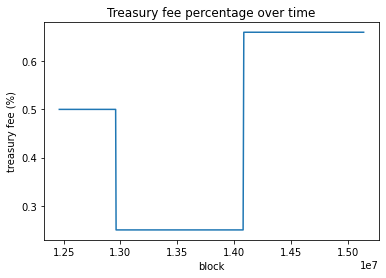

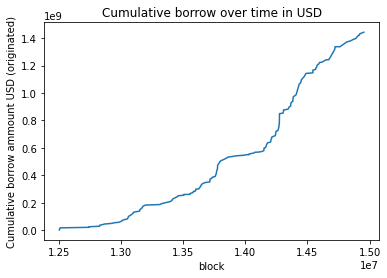

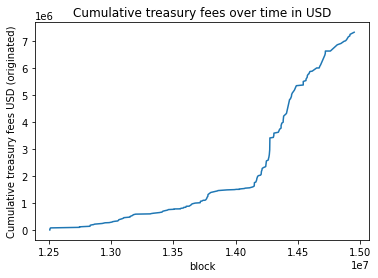

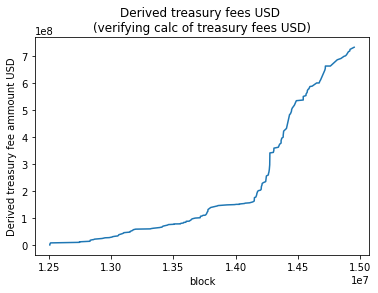

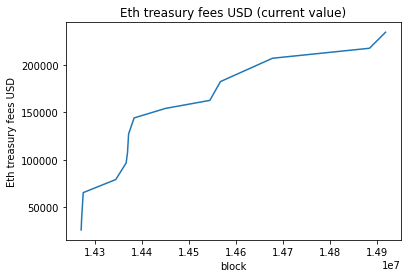

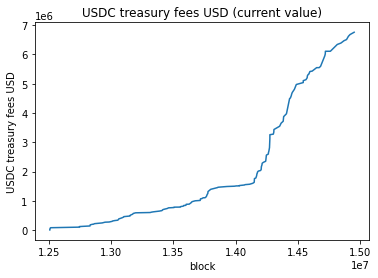

In [128]:
# Treasury fee discrepency analysis

financialSnapshots = messari_maple.Query.financialsDailySnapshots(first=1000000, orderBy=messari_maple.FinancialsDailySnapshot.blockNumber)
borrows = messari_maple.Query.borrows(first=1000000, orderBy=messari_maple.Borrow.blockNumber)

(treasuryFeeBlocks, treasuryFees) = sg.query([
    financialSnapshots.blockNumber,
    financialSnapshots._treasuryFee,
])

treasuryFeePercentages = np.array(treasuryFees) * 100

plt.plot(treasuryFeeBlocks, treasuryFeePercentages)
plt.xlabel("block")
plt.ylabel("treasury fee (%)")
plt.title("Treasury fee percentage over time")

(borrowBlocks, treasuryFeesPaid, treasuryFeesPaidUSD, borrowAmountUSD, symbol) = sg.query([
   borrows.blockNumber,
   borrows._treasuryFeePaid,
   borrows._treasuryFeePaidUSD,
   borrows.amountUSD,
   borrows.asset.symbol
])

interpolatedTreasuryFees = np.interp(borrowBlocks,treasuryFeeBlocks,treasuryFeePercentages)
# plt.figure()
# plt.plot(borrowBlocks,interpolatedTreasuryFees)
# plt.xlabel("block")
# plt.ylabel("interpolated treasury fee (%)")
# plt.title("Interpolated treasury fee percentage over time")

plt.figure()
plt.plot(borrowBlocks, np.cumsum(borrowAmountUSD))
plt.xlabel("block")
plt.ylabel("Cumulative borrow ammount USD (originated)")
plt.title("Cumulative borrow over time in USD")

plt.figure()
plt.plot(borrowBlocks, np.cumsum(treasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("Cumulative treasury fees USD (originated)")
plt.title("Cumulative treasury fees over time in USD")

derivedTreasuryFeesUSD = np.array(borrowAmountUSD) * np.array(interpolatedTreasuryFees)
plt.figure()
plt.plot(borrowBlocks, np.cumsum(derivedTreasuryFeesUSD))
plt.xlabel("block")
plt.ylabel("Derived treasury fee ammount USD")
plt.title("Derived treasury fees USD \n(verifying calc of treasury fees USD)")


# ethBorrowsBase = messari_maple.Query.borrows(where=[messari_maple.Borrow.decimals==12])
# usdcBorrowsBase = messari_maple.Query.borrows(first=1000000, orderBy=messari_maple.Borrow.blockNumber, where=[messari_maple.Borrow.asset.name=="USDC"])

# (ethBorrowBlocks, ethTreasuryFeesPaid) = sg.query([
#     ethBorrowsBase.blockNumber,
#     ethBorrowsBase._treasuryFeePaid,
# ])


ethTokenToUSD = 1 / (10**18) * ethPriceUSD
usdcTokenToUSD = 1 / (10**6) 

ethIndicies = np.where(np.array(symbol) == 'WETH')
ethBlocks = np.array(borrowBlocks)[ethIndicies] 
ethTreasuryFeesPaid = np.array(treasuryFeesPaid)[ethIndicies]
ethTreasuryFeesPaidUSD = ethTreasuryFeesPaid * ethTokenToUSD 

plt.figure()
plt.plot(ethBlocks, np.cumsum(ethTreasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("Eth treasury fees USD")
plt.title("Eth treasury fees USD (current value)")


usdcIndicies = np.where(np.array(symbol) == "USDC")
usdcBlocks = np.array(borrowBlocks)[usdcIndicies] 
usdcTreasuryFeesPaid = np.array(treasuryFeesPaid)[usdcIndicies]
usdcTreasuryFeesPaidUSD = usdcTreasuryFeesPaid * usdcTokenToUSD 

plt.figure()
plt.plot(usdcBlocks, np.cumsum(usdcTreasuryFeesPaidUSD))
plt.xlabel("block")
plt.ylabel("USDC treasury fees USD")
plt.title("USDC treasury fees USD (current value)")





In [129]:
# Report results

print(checks)

{'unique_users_self_consistant': False, 'market_cumulatives_match': True}


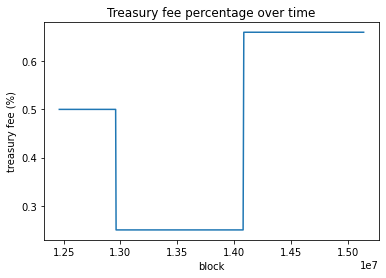

In [130]:
ethTokenToUSD = 1 / (10**18) * ethPriceUSD
usdcTokenToUSD = 1 / (10**6) 

financialSnapshots = messari_maple.Query.financialsDailySnapshots(first=1000000, orderBy=messari_maple.FinancialsDailySnapshot.blockNumber)
borrows = messari_maple.Query.borrows(first=1000000, orderBy=messari_maple.Borrow.blockNumber)

(treasuryFeeBlocks, treasuryFees) = sg.query([
    financialSnapshots.blockNumber,
    financialSnapshots._treasuryFee,
])

treasuryFeePercentages = np.array(treasuryFees) * 100

plt.plot(treasuryFeeBlocks, treasuryFeePercentages)
plt.xlabel("block")
plt.ylabel("treasury fee (%)")
plt.title("Treasury fee percentage over time")

(borrowBlocks, treasuryFeesPaid, treasuryFeesPaidUSD, borrowAmountUSD, symbol) = sg.query([
   borrows.blockNumber,
   borrows._treasuryFeePaid,
   borrows._treasuryFeePaidUSD,
   borrows.amountUSD,
   borrows.asset.symbol
])




In [131]:
marketAddress = "0xfebd6f15df3b73dc4307b1d7e65d46413e710c27"

deposits = messari_maple.Query.deposits(first=1000000, orderBy=messari_maple.Deposit.blockNumber, where=[messari_maple.Deposit.market==marketAddress])
withdraws = messari_maple.Query.withdraws(first=1000000, orderBy=messari_maple.Withdraw.blockNumber, where=[messari_maple.Withdraw.market==marketAddress])

(depositAmounts, withdrawAmounts, lossesAmounts) = sg.query([
   deposits.amount,
   withdraws.amount,
   withdraws._losses
])


derivedCumulativeDeposit = sum(depositAmounts)
derivedCumulativeWithdraw = sum(withdrawAmounts)
derivedCumulativeLosses = sum(lossesAmounts)


print(len(withdrawAmounts))

print(f"Derived cumulative deposit: {derivedCumulativeDeposit}" )
print(f"Derived cumulative withdraw: {derivedCumulativeWithdraw}" )
print(f"Derived cumulative recognized losses: {derivedCumulativeLosses}" )


217
Derived cumulative deposit: 447622619327527
Derived cumulative withdraw: 217970609360914
Derived cumulative recognized losses: 817160150936
